## 2E-VREC Problem Solver using ALNS

In [35]:
import random
from typing import List, Dict, Set, Tuple, Optional
import numpy as np
from alns import ALNS,State
from alns.accept import SimulatedAnnealing
from alns.select import RouletteWheel
from alns.stop import MaxIterations

import numpy.random as rnd

SEED = 1234


In [36]:
class VehicleRoute:
    """
    Represents a van or robot route in the 2E-VREC problem.
    """
    def __init__(self, is_van_route: bool = True):
        self.nodes: List[int] = []  # List of nodes in the route
        self.is_van_route: bool = is_van_route
        # Whether robot is on the van for each segment (van routes only)
        self.robot_onboard: List[bool] = []
        # Amount to recharge at each node
        self.recharge_amount: Dict[int, float] = {}
        # Amount to charge en-route (van routes only)
        self.en_route_charge: Dict[Tuple[int, int], float] = {}

    def copy(self) -> "VehicleRoute":
        """Creates a deep copy of the VehicleRoute object."""
        route = VehicleRoute(self.is_van_route)
        route.nodes = self.nodes.copy()
        route.robot_onboard = self.robot_onboard.copy()
        route.recharge_amount = self.recharge_amount.copy()
        route.en_route_charge = self.en_route_charge.copy()
        return route

    def __str__(self) -> str:
        route_type = "Van" if self.is_van_route else "Robot"
        return f"{route_type} Route: {self.nodes}"

In [37]:
class VRPECSolution(State):
    """
    Represents a solution to the 2E-VREC problem.
    """

    def __init__(self,
                 distance_matrix: np.ndarray,
                 depot: int,
                 charging_stations: List[int],
                 customers_robot_only: List[int],
                 customers_both: List[int],
                 van_params: Dict[str, float],
                 robot_params: Dict[str, float],
                 customer_demand: Dict[int, float],
                 time_windows: Dict[int, Tuple[float, float]],
                 service_times: Dict[int, float]):
        # Problem data
        self.distance_matrix: np.ndarray = distance_matrix
        self.depot: int = depot
        self.charging_stations: List[int] = charging_stations
        self.customers_robot_only: List[int] = customers_robot_only
        self.customers_both: List[int] = customers_both
        self.all_customers: List[int] = customers_robot_only + customers_both
        self.van_params: Dict[str, float] = van_params
        self.robot_params: Dict[str, float] = robot_params
        self.customer_demand: Dict[int, float] = customer_demand
        self.time_windows: Dict[int, Tuple[float, float]] = time_windows
        self.service_time:Dict[int,float] = service_times

        # Solution data
        self.van_routes: List[VehicleRoute] = []
        self.robot_routes: List[VehicleRoute] = []
        self.unassigned_customers: Set[int] = set(self.all_customers)

    def copy(self) -> "VRPECSolution":
        """Create a deep copy of the solution state."""
        solution = VRPECSolution(
            self.distance_matrix,
            self.depot,
            self.charging_stations,
            self.customers_robot_only,
            self.customers_both,
            self.van_params,
            self.robot_params,
            self.customer_demand,
            self.time_windows,
            self.service_time
        )
        solution.van_routes = [route.copy() for route in self.van_routes]
        solution.robot_routes = [route.copy() for route in self.robot_routes]
        solution.unassigned_customers = self.unassigned_customers.copy()
        return solution

    def objective(self) -> float:
        """
        Tính tổng chi phí của giải pháp, bao gồm chi phí di chuyển và chi phí thời gian.
        """
        total_cost = 0.0

        # **Chi phí di chuyển cho van**
        for route in self.van_routes:
            if len(route.nodes) > 1:
                for i in range(len(route.nodes) - 1):
                    node1, node2 = route.nodes[i], route.nodes[i + 1]
                    distance = self.distance_matrix[node1][node2]
                    total_cost += (self.van_params["travel_cost_rate"] * distance)

        # **Chi phí di chuyển cho robot**
        for route in self.robot_routes:
            if len(route.nodes) > 1:
                for i in range(len(route.nodes) - 1):
                    node1, node2 = route.nodes[i], route.nodes[i + 1]
                    distance = self.distance_matrix[node1][node2]
                    total_cost += (self.robot_params["travel_cost_rate"] * distance )

        
        # **Phạt nếu có khách hàng không được phục vụ**
        for cus in self.unassigned_customers:
            total_cost += self.customer_demand[cus] * 1000

        return total_cost

    def time_warp_calculating(self, route:List, depart_time=0):
        time = depart_time
        for i in range(len(route) - 1):
            start, end = self.time_windows[route[i + 1]]
            time += self.distance_matrix[route[i]][route[i + 1]] / self.van_params['speed']
            time = max(time, start)

            if time > end:
                return False
            else:
                time += self.service_time[route[i + 1]]
        earliest_time = time
        route.reverse()
        time = earliest_time
        for i in range(len(route) - 1):
            start, end = self.time_windows[route[i + 1]]
            time -= self.distance_matrix[route[i]][route[i + 1]] - self.service_time[route[i + 1]]
            time = max(start, time)
            time = min(end, time)

            if start > time:
                return False

        time_warp = time - depart_time
        return time_warp


    def four_step_heuristic(self, route: VehicleRoute):
        pass
        
    def is_feasible(self) -> bool:
        """
        Check if the solution is feasible:
            - All customers are served
            - Vehicle capacities are respected
            - Energy constraints are respected
            - Every robot can complete its route given battery constraints
            - Time windows are respected
        """
        if self.unassigned_customers:
            return False
        
        if len(self.van_routes) == 0 or len(self.robot_routes) == 0:
            return False
        
        if len(self.van_routes) > 1:
            return False

        return all(self._is_van_route_feasible(route, i)
                   for i, route in enumerate(self.van_routes)) and \
               all(self._is_robot_route_feasible(route, i)
                   for i, route in enumerate(self.robot_routes))

    def _is_van_route_feasible(self, route: VehicleRoute, route_idx: int) -> bool:
        """Check if a van route is feasible."""
        if not route.nodes:
            return True
        if route.nodes[0] != self.depot or route.nodes[-1] != self.depot:
            return False

        # Kiểm tra không có khách hàng sau khách hàng cuối cùng trước depot
        last_customer_idx = -1
        for i in range(len(route.nodes) - 1, 0, -1):
            if route.nodes[i] in self.all_customers:
                last_customer_idx = i
                break
        if last_customer_idx > 0:
            for i in range(last_customer_idx + 1, len(route.nodes) - 1):
                if route.nodes[i] in self.all_customers:
                    return False

        battery_level = self.van_params["battery_capacity"]
        load = 0
        for i in range(len(route.nodes) - 1):
            node1, node2 = route.nodes[i], route.nodes[i + 1]
            if node1 in self.all_customers:
                load += self.customer_demand[node1]
            distance = self.distance_matrix[node1][node2]
            energy_consumption = (distance) * self.van_params["energy_consumption_rate"]
            en_route_charge = route.en_route_charge.get((node1, node2), 0)
            if node1 in self.charging_stations:
                recharge_amount = route.recharge_amount.get(node1, 0)
                battery_level = min(battery_level + recharge_amount, self.van_params["battery_capacity"])
            if battery_level < energy_consumption + en_route_charge:
                return False
            battery_level -= energy_consumption + en_route_charge
        return load <= self.van_params["capacity"]

    def _is_robot_route_feasible(self, route: VehicleRoute, route_idx: int) -> bool:
        """Check if a robot route is feasible."""
        if not route.nodes:
            return True
        if (route.nodes[0] not in self.charging_stations or
                route.nodes[-1] not in self.charging_stations):
            return False

        battery_level = route.recharge_amount.get(route.nodes[0], 0)
        load = 0
        for i in range(len(route.nodes) - 1):
            node1, node2 = route.nodes[i], route.nodes[i + 1]
            if node1 in self.all_customers:
                load += self.customer_demand[node1]
            distance = self.distance_matrix[node1][node2]
            energy_consumption = (distance) * self.robot_params["energy_consumption_rate"]
            if node1 in self.charging_stations:
                recharge_amount = route.recharge_amount.get(node1, 0)
                battery_level = min(battery_level + recharge_amount, self.robot_params["battery_capacity"])
            battery_level -= energy_consumption
            if battery_level < 0:
                return False
        return load <= self.robot_params["capacity"]

    def _can_van_visit_customer(self, route: VehicleRoute, customer: int) -> bool:
        """Check if a van can visit a customer directly."""
        if customer in self.customers_robot_only:
            return False
        return self.customer_demand[customer] <= self.van_params["capacity"]

    def create_initial_solution(self) -> "VRPECSolution":
        """
        Create an initial feasible solution. Uses a simple greedy approach
        to assign customers to routes.
        """
        solution = self.copy()
        solution.unassigned_customers = set(self.all_customers)
        van_route = VehicleRoute(is_van_route=True)
        van_route.nodes = [self.depot]
        station_distances = [(s, self.distance_matrix[self.depot][s])
                             for s in self.charging_stations]
        station_distances.sort(key=lambda x: x[1])
        closest_station = station_distances[0][0]
        van_route.nodes.append(closest_station)
        van_route.robot_onboard = [True]
        robot_route = VehicleRoute(is_van_route=False)
        robot_route.nodes = [closest_station]
        customers_to_visit = list(solution.unassigned_customers)
        customers_to_visit.sort(key=lambda c: self.distance_matrix[closest_station][c])
        total_load = 0
        for customer in customers_to_visit:
            if customer in solution.customers_both:
                if random.random() < 0.5 and self._can_van_visit_customer(van_route, customer):
                    van_route.nodes.insert(-1, customer)
                    van_route.robot_onboard.append(True)
                    solution.unassigned_customers.remove(customer)
                    continue
            if total_load + self.customer_demand[customer] <= self.robot_params["capacity"]:
                robot_route.nodes.append(customer)
                total_load += self.customer_demand[customer]
                solution.unassigned_customers.remove(customer)
        robot_route.nodes.append(closest_station)
        van_route.nodes.append(self.depot)
        van_route.robot_onboard.append(True)
        van_route.recharge_amount[closest_station] = self.van_params["battery_capacity"] / 2
        robot_route.recharge_amount[closest_station] = self.robot_params["battery_capacity"]
        solution.van_routes.append(van_route)
        solution.robot_routes.append(robot_route)
        while solution.unassigned_customers:
            new_van_route = VehicleRoute(is_van_route=True)
            new_van_route.nodes = [self.depot, closest_station, self.depot]
            new_van_route.robot_onboard = [True, True]
            new_robot_route = VehicleRoute(is_van_route=False)
            new_robot_route.nodes = [closest_station]
            customers_to_visit = list(solution.unassigned_customers)
            customers_to_visit.sort(key=lambda c: self.distance_matrix[closest_station][c])
            total_load = 0
            for customer in customers_to_visit:
                if total_load + self.customer_demand[customer] <= self.robot_params["capacity"]:
                    new_robot_route.nodes.append(customer)
                    total_load += self.customer_demand[customer]
                    solution.unassigned_customers.remove(customer)
            if len(new_robot_route.nodes) > 1:
                new_robot_route.nodes.append(closest_station)
                new_robot_route.recharge_amount[closest_station] = self.robot_params["battery_capacity"]
                new_van_route.recharge_amount[closest_station] = self.van_params["battery_capacity"] / 2
                solution.van_routes.append(new_van_route)
                solution.robot_routes.append(new_robot_route)
            else:
                break
        return solution


In [38]:
def random_customer_removal(solution: VRPECSolution,
                            random_state: np.random.RandomState) -> VRPECSolution:
    """
    Remove a random customer from the solution.
    """
    destroyed = solution.copy()
    assigned_customers = [c for c in destroyed.all_customers
                          if c not in destroyed.unassigned_customers]

    if not assigned_customers:
        return destroyed  # No customers to remove

    customer_to_remove = random_state.choice(assigned_customers)

    for route in destroyed.van_routes:
        if customer_to_remove in route.nodes:
            idx = route.nodes.index(customer_to_remove)
            route.nodes.pop(idx)
            if idx < len(route.robot_onboard):
                route.robot_onboard.pop(idx)

    for route in destroyed.robot_routes:
        if customer_to_remove in route.nodes:
            route.nodes.remove(customer_to_remove)

    destroyed.unassigned_customers.add(customer_to_remove)
    return destroyed

def greedy_customer_removal(solution: VRPECSolution) -> VRPECSolution:
    """
    Remove the customer that causes the least increase in cost when removed.
    """
    destroyed = solution.copy()
    assigned_customers = [c for c in destroyed.all_customers
                          if c not in destroyed.unassigned_customers]

    if not assigned_customers:
        return destroyed  # No customers to remove

    best_customer = None
    best_cost_increase = float('inf')

    for customer in assigned_customers:
        cost_increase = 0.0

        for route in destroyed.van_routes:
            if customer in route.nodes:
                idx = route.nodes.index(customer)
                prev_node = route.nodes[idx - 1]
                next_node = route.nodes[idx + 1] if idx < len(route.nodes) - 1 else route.nodes[0]
                cost_increase += (destroyed.distance_matrix[prev_node][next_node] -
                                  destroyed.distance_matrix[prev_node][customer] -
                                  destroyed.distance_matrix[customer][next_node])* destroyed.van_params["travel_cost_rate"]/ destroyed.van_params["speed"]

        for route in destroyed.robot_routes:
            if customer in route.nodes:
                idx = route.nodes.index(customer)
                prev_node = route.nodes[idx - 1]
                next_node = route.nodes[idx + 1] if idx < len(route.nodes) - 1 else route.nodes[0]
                cost_increase += (destroyed.distance_matrix[prev_node][next_node] -
                                  destroyed.distance_matrix[prev_node][customer] -
                                  destroyed.distance_matrix[customer][next_node]) * destroyed.robot_params["travel_cost_rate"] / destroyed.robot_params["speed"]

        if cost_increase < best_cost_increase:
            best_cost_increase = cost_increase
            best_customer = customer

    for route in destroyed.van_routes:
        if best_customer in route.nodes:
            idx = route.nodes.index(best_customer)
            route.nodes.pop(idx)
            if idx < len(route.robot_onboard):
                route.robot_onboard.pop(idx)

    for route in destroyed.robot_routes:
        if best_customer in route.nodes:
            route.nodes.remove(best_customer)

    destroyed.unassigned_customers.add(best_customer)
    return destroyed
def customer_removal(solution: VRPECSolution, random_state: np.random.RandomState, beta = 0.3) -> VRPECSolution:
    rand_num = np.random.rand()
    if rand_num < beta:
        destroyed = random_customer_removal(solution, random_state)
    else:
        destroyed = greedy_customer_removal(solution)
    return destroyed

def station_removal(solution: VRPECSolution,
                    random_state: np.random.RandomState) -> VRPECSolution:
    """
    Remove a random charging station and its associated robot routes.
    """
    destroyed = solution.copy()
    used_stations = set()
    for route in destroyed.van_routes:
        for node in route.nodes:
            if node in destroyed.charging_stations:
                used_stations.add(node)

    if not used_stations:
        return destroyed  # No stations to remove

    station_to_remove = random_state.choice(list(used_stations))

    routes_to_remove = []
    for i, route in enumerate(destroyed.robot_routes):
        if station_to_remove in route.nodes:
            routes_to_remove.append(i)
            for node in route.nodes:
                if node in destroyed.all_customers:
                    destroyed.unassigned_customers.add(node)

    for i in sorted(routes_to_remove, reverse=True):
        destroyed.robot_routes.pop(i)

    for route in destroyed.van_routes:
        if station_to_remove in route.nodes:
            idx = route.nodes.index(station_to_remove)
            if 0 < idx < len(route.nodes) - 1:
                route.nodes.pop(idx)
                if idx < len(route.robot_onboard):
                    route.robot_onboard.pop(idx)

    return destroyed

def random_route_closure(solution: VRPECSolution,
                         random_state: np.random.RandomState) -> VRPECSolution:
    """
    remove all customers from a random route (van or robot) and mark them as unassigned.
    """
    destroyed = solution.copy()
    if not destroyed.van_routes and not destroyed.robot_routes:
        return destroyed  # No routes to destroy
    
    route_to_closure = []
    for route in destroyed.van_routes + destroyed.robot_routes:
        if route.nodes:
            route_to_closure.append(route)

    route_removed = random_state.choice(route_to_closure)
    for node in route_removed.nodes:
        if node in destroyed.all_customers:
            destroyed.unassigned_customers.add(node)

    if route_removed.is_van_route:
        destroyed.van_routes.remove(route_removed)
    else:
        destroyed.robot_routes.remove(route_removed)
    
    return destroyed

def greedy_route_closure(solution: VRPECSolution) -> VRPECSolution:
    """
    Remove the route that causes the least increase in cost when removed.
    """
    destroyed = solution.copy()

    if not destroyed.van_routes and not destroyed.robot_routes:
        return destroyed
    
    candidate_routes = destroyed.van_routes + destroyed.robot_routes
    best_route = None
    best_cost = float('inf')
    
    for route in candidate_routes:
        if route in destroyed.van_routes:
            cost_rate = destroyed.van_params["travel_cost_rate"]
            speed = destroyed.van_params["speed"]
        else:
            cost_rate = destroyed.robot_params["travel_cost_rate"]
            speed = destroyed.robot_params["speed"]

        cost = 0.0
        for i in range(len(route.nodes) - 1):
            node1, node2 = route.nodes[i], route.nodes[i + 1]
            distance = destroyed.distance_matrix[node1][node2]

        cost += (cost_rate * distance / speed)

        if cost > best_cost:
            best_cost = cost
            best_route = route

    if best_route:
        for node in best_route.nodes:
            if node in destroyed.all_customers:
                destroyed.unassigned_customers.add(node)

        if best_route.is_van_route:
            destroyed.van_routes.remove(best_route)
        else:
            destroyed.robot_routes.remove(best_route)

    return destroyed

def route_closure(solution: VRPECSolution, random_state: np.random.RandomState, beta = 0.3) -> VRPECSolution:
    rand_num = np.random.rand()
    if rand_num < beta:
        destroyed = random_route_closure(solution, random_state)
    else:
        destroyed = greedy_route_closure(solution)
    return destroyed


def route_destruction(solution: VRPECSolution,
                      random_state: np.random.RandomState) -> VRPECSolution:
    """
    Destroy a random van route and its associated robot routes.
    """
    destroyed = solution.copy()
    if not destroyed.van_routes:
        return destroyed  # Nocustomer_demand routes to destroy

    van_route_idx = random_state.randint(0, len(destroyed.van_routes))

    if van_route_idx < len(destroyed.van_routes):
        van_route = destroyed.van_routes[van_route_idx]

        for node in van_route.nodes:
            if node in destroyed.all_customers:
                destroyed.unassigned_customers.add(node)

        stations_in_route = [node for node in van_route.nodes
                             if node in destroyed.charging_stations]

        routes_to_remove = []
        for i, route in enumerate(destroyed.robot_routes):
            if any(station in route.nodes for station in stations_in_route):
                routes_to_remove.append(i)
                for node in route.nodes:
                    if node in destroyed.all_customers:
                        destroyed.unassigned_customers.add(node)

        for i in sorted(routes_to_remove, reverse=True):
            destroyed.robot_routes.pop(i)

        destroyed.van_routes.pop(van_route_idx)

    return destroyed

In [39]:
def greedy_repair(solution: VRPECSolution,
                  random_state: np.random.RandomState) -> VRPECSolution:
    """
    Repair by greedily inserting unassigned customers into existing routes.
    """
    repaired = solution.copy()
    unassigned = list(repaired.unassigned_customers)
    random_state.shuffle(unassigned)

    for customer in unassigned:
        best_cost = float('inf')
        best_insert = None

        # Try to insert into van routes
        if customer in repaired.customers_both:
            for r_idx, route in enumerate(repaired.van_routes):
                for pos in range(1, len(route.nodes)):
                    prev_node, next_node = route.nodes[pos - 1], route.nodes[pos]
                    old_cost = (repaired.van_params["travel_cost_rate"] *
                                repaired.distance_matrix[prev_node][next_node])
                    new_cost = (repaired.van_params["travel_cost_rate"] *
                                (repaired.distance_matrix[prev_node][customer] +
                                 repaired.distance_matrix[customer][next_node]))
                    delta = new_cost - old_cost

                    if delta < best_cost:
                        temp_route = route.copy()
                        temp_route.nodes.insert(pos, customer)
                        temp_route.robot_onboard.insert(
                            pos - 1,
                            (route.robot_onboard[pos - 1]
                             if pos - 1 < len(route.robot_onboard) else False)
                        )

                        if repaired._is_van_route_feasible(temp_route, r_idx):
                            best_cost = delta
                            best_insert = ('van', r_idx, pos)

        # Try to insert into robot routes
        for r_idx, route in enumerate(repaired.robot_routes):
            for pos in range(1, len(route.nodes)):
                prev_node, next_node = route.nodes[pos - 1], route.nodes[pos]
                old_cost = (repaired.robot_params["travel_cost_rate"] *
                            repaired.distance_matrix[prev_node][next_node])
                new_cost = (repaired.robot_params["travel_cost_rate"] *
                            (repaired.distance_matrix[prev_node][customer] +
                             repaired.distance_matrix[customer][next_node]))
                delta = new_cost - old_cost

                if delta < best_cost:
                    temp_route = route.copy()
                    temp_route.nodes.insert(pos, customer)

                    if repaired._is_robot_route_feasible(temp_route, r_idx):
                        best_cost = delta
                        best_insert = ('robot', r_idx, pos)

        if best_insert:
            route_type, r_idx, pos = best_insert
            if route_type == 'van':
                repaired.van_routes[r_idx].nodes.insert(pos, customer)
                repaired.van_routes[r_idx].robot_onboard.insert(
                    pos - 1,
                    (repaired.van_routes[r_idx].robot_onboard[pos - 1]
                     if pos - 1 < len(repaired.van_routes[r_idx].robot_onboard)
                     else False)
                )
            else:  # robot
                repaired.robot_routes[r_idx].nodes.insert(pos, customer)
            repaired.unassigned_customers.remove(customer)
        else:
            # Create a new route (van or robot)
            if customer in repaired.customers_both:
                new_van_route = VehicleRoute(is_van_route=True)
                new_van_route.nodes = [repaired.depot, customer, repaired.depot]
                new_van_route.robot_onboard = [False, False]

                if repaired._is_van_route_feasible(new_van_route,
                                                  len(repaired.van_routes)):
                    repaired.van_routes.append(new_van_route)
                    repaired.unassigned_customers.remove(customer)
                    continue

            # Try to extend an existing van route to a charging station
            best_extension_cost = float('inf')
            best_extension = None
            
            # First find best charging station for this customer
            station_distances = [
                (s, repaired.distance_matrix[customer][s])
                for s in repaired.charging_stations
            ]
            station_distances.sort(key=lambda x: x[1])
            
            # Try extending existing van routes to appropriate charging stations
            for cs_idx, (charging_station, _) in enumerate(station_distances):
                # Only check the closest few stations
                if cs_idx > 2:  # Limit to checking top 3 closest stations
                    break
                
                # Try adding to existing routes with robots
                for r_idx, route in enumerate(repaired.van_routes):
                    if not any(route.robot_onboard):
                        continue  # Skip routes without robots
                    
                    # Check if charging station is already in the route
                    if charging_station in route.nodes:
                        continue
                        
                    # Try inserting charging station at each position
                    for pos in range(1, len(route.nodes)):
                        prev_node, next_node = route.nodes[pos-1], route.nodes[pos]
                        
                        # Cost of detour to visit this charging station
                        detour_cost = (
                            repaired.distance_matrix[prev_node][charging_station] + 
                            repaired.distance_matrix[charging_station][next_node] -
                            repaired.distance_matrix[prev_node][next_node]
                        ) * repaired.van_params["travel_cost_rate"]
                        
                        if detour_cost < best_extension_cost:
                            temp_route = route.copy()
                            temp_route.nodes.insert(pos, charging_station)
                            temp_route.robot_onboard.insert(pos-1, True)
                            temp_route.robot_onboard.insert(pos, True)
                            
                            # Set recharging at the station
                            temp_route.recharge_amount[charging_station] = (
                                repaired.van_params["battery_capacity"] / 2)
                            
                            if repaired._is_van_route_feasible(temp_route, r_idx):
                                # Check if robot route would be feasible
                                new_robot_route = VehicleRoute(is_van_route=False)
                                new_robot_route.nodes = [charging_station, customer, charging_station]
                                new_robot_route.recharge_amount[charging_station] = (
                                    repaired.robot_params["battery_capacity"])
                                
                                if repaired._is_robot_route_feasible(new_robot_route, 
                                                              len(repaired.robot_routes)):
                                    best_extension_cost = detour_cost
                                    best_extension = (r_idx, pos, charging_station)
            
            # If we found a good extension, use it
            if best_extension:
                r_idx, pos, station = best_extension
                
                # Update van route
                repaired.van_routes[r_idx].nodes.insert(pos, station)
                repaired.van_routes[r_idx].robot_onboard.insert(pos-1, True)
                repaired.van_routes[r_idx].robot_onboard.insert(pos, True)
                repaired.van_routes[r_idx].recharge_amount[station] = (
                    repaired.van_params["battery_capacity"] / 2)
                
                # Create new robot route
                new_robot_route = VehicleRoute(is_van_route=False)
                new_robot_route.nodes = [station, customer, station]
                new_robot_route.recharge_amount[station] = repaired.robot_params["battery_capacity"]
                repaired.robot_routes.append(new_robot_route)
                repaired.unassigned_customers.remove(customer)
                continue
                
            # If no good extension, create a new route
            for charging_station, _ in station_distances:
                new_van_route = VehicleRoute(is_van_route=True)
                new_van_route.nodes = [repaired.depot, charging_station, repaired.depot]
                new_van_route.robot_onboard = [True, True]
                new_van_route.recharge_amount[charging_station] = (
                    repaired.van_params["battery_capacity"] / 2)

                new_robot_route = VehicleRoute(is_van_route=False)
                new_robot_route.nodes = [charging_station, customer, charging_station]
                new_robot_route.recharge_amount[charging_station] = (
                    repaired.robot_params["battery_capacity"])

                if (repaired._is_van_route_feasible(
                        new_van_route, len(repaired.van_routes)) and
                        repaired._is_robot_route_feasible(
                            new_robot_route, len(repaired.robot_routes))):
                    repaired.van_routes.append(new_van_route)
                    repaired.robot_routes.append(new_robot_route)
                    repaired.unassigned_customers.remove(customer)
                    break  # Added, move to next customer

    return repaired

def nearest_station_insertion(solution: VRPECSolution) -> VRPECSolution:
    pass

def route_reconstruction(solution: VRPECSolution,
                         random_state: np.random.RandomState) -> VRPECSolution:
    """
    Reconstruct routes for all unassigned customers.
    """
    reconstructed = solution.copy()
    if not reconstructed.unassigned_customers:
        return reconstructed

    unassigned = list(reconstructed.unassigned_customers)
    unassigned.sort(key=lambda c: reconstructed.customer_demand[c],
                    reverse=True)  # Sort by demand (descending)

    # Group customers by region/proximity
    if len(unassigned) > 1:
        # Use simple clustering by nearest charging station
        customer_groups = {}
        for customer in unassigned:
            nearest_station = min(
                reconstructed.charging_stations,
                key=lambda s: reconstructed.distance_matrix[customer][s]
            )
            if nearest_station not in customer_groups:
                customer_groups[nearest_station] = []
            customer_groups[nearest_station].append(customer)
    else:
        # Just one customer
        customer_groups = {0: unassigned}

    # Process each group
    for station, customers in customer_groups.items():
        # First try to add customers to existing robot routes
        for customer in customers[:]:  # Work with a copy to allow removals
            best_insert_cost = float('inf')
            best_robot_route = None
            best_pos = None
            
            for r_idx, route in enumerate(reconstructed.robot_routes):
                # Only consider routes that start/end at the appropriate station
                if route.nodes[0] != station:
                    continue
                    
                for pos in range(1, len(route.nodes)):
                    prev, next_node = route.nodes[pos-1], route.nodes[pos]
                    old_cost = reconstructed.distance_matrix[prev][next_node]
                    new_cost = (reconstructed.distance_matrix[prev][customer] +
                               reconstructed.distance_matrix[customer][next_node])
                    delta = new_cost - old_cost
                    
                    if delta < best_insert_cost:
                        temp_route = route.copy()
                        temp_route.nodes.insert(pos, customer)
                        
                        if reconstructed._is_robot_route_feasible(temp_route, r_idx):
                            best_insert_cost = delta
                            best_robot_route = r_idx
                            best_pos = pos
            
            if best_robot_route is not None:
                reconstructed.robot_routes[best_robot_route].nodes.insert(best_pos, customer)
                customers.remove(customer)
                reconstructed.unassigned_customers.remove(customer)

        # For remaining customers, try direct van delivery or new robot routes
        for customer in customers:
            if (customer in reconstructed.customers_both and
                    random_state.random() < 0.5):
                # Try to use van directly
                new_van_route = VehicleRoute(is_van_route=True)
                new_van_route.nodes = [reconstructed.depot, customer,
                                      reconstructed.depot]
                new_van_route.robot_onboard = [False, False]

                if reconstructed._is_van_route_feasible(
                        new_van_route, len(reconstructed.van_routes)):
                    reconstructed.van_routes.append(new_van_route)
                    reconstructed.unassigned_customers.remove(customer)
                    continue

            # Try to extend an existing van route to this station
            best_extension_cost = float('inf')
            best_extension = None
            
            for r_idx, route in enumerate(reconstructed.van_routes):
                if station in route.nodes:
                    continue  # Station already in route
                    
                for pos in range(1, len(route.nodes)):
                    prev_node, next_node = route.nodes[pos-1], route.nodes[pos]
                    
                    detour_cost = (
                        reconstructed.distance_matrix[prev_node][station] + 
                        reconstructed.distance_matrix[station][next_node] -
                        reconstructed.distance_matrix[prev_node][next_node]
                    ) * reconstructed.van_params["travel_cost_rate"]
                    
                    if detour_cost < best_extension_cost:
                        temp_route = route.copy()
                        temp_route.nodes.insert(pos, station)
                        
                        # Extend robot_onboard list consistently
                        robot_insertion_idx = pos - 1
                        if robot_insertion_idx < len(route.robot_onboard):
                            robot_onboard_val = route.robot_onboard[robot_insertion_idx]
                            temp_route.robot_onboard.insert(robot_insertion_idx, robot_onboard_val)
                            temp_route.robot_onboard.insert(robot_insertion_idx + 1, True)
                        else:
                            temp_route.robot_onboard.append(True)
                        
                        temp_route.recharge_amount[station] = (
                            reconstructed.van_params["battery_capacity"] / 2)
                        
                        if reconstructed._is_van_route_feasible(temp_route, r_idx):
                            best_extension_cost = detour_cost
                            best_extension = (r_idx, pos)
            
            if best_extension:
                r_idx, pos = best_extension
                # Update van route
                reconstructed.van_routes[r_idx].nodes.insert(pos, station)
                
                # Update robot_onboard list
                robot_insertion_idx = pos - 1
                if robot_insertion_idx < len(reconstructed.van_routes[r_idx].robot_onboard):
                    robot_onboard_val = reconstructed.van_routes[r_idx].robot_onboard[robot_insertion_idx]
                    reconstructed.van_routes[r_idx].robot_onboard.insert(robot_insertion_idx, robot_onboard_val)
                    reconstructed.van_routes[r_idx].robot_onboard.insert(robot_insertion_idx + 1, True)
                else:
                    reconstructed.van_routes[r_idx].robot_onboard.append(True)
                
                reconstructed.van_routes[r_idx].recharge_amount[station] = (
                    reconstructed.van_params["battery_capacity"] / 2)
                
                # Create new robot route
                new_robot_route = VehicleRoute(is_van_route=False)
                new_robot_route.nodes = [station, customer, station]
                new_robot_route.recharge_amount[station] = (
                    reconstructed.robot_params["battery_capacity"])
                
                reconstructed.robot_routes.append(new_robot_route)
                reconstructed.unassigned_customers.remove(customer)
                continue

            # Need to use a robot with new van route, find appropriate station
            station_distances = [
                (s, reconstructed.distance_matrix[customer][s])
                for s in reconstructed.charging_stations
            ]
            station_distances.sort(key=lambda x: x[1])

            for station, _ in station_distances:
                new_van_route = VehicleRoute(is_van_route=True)
                new_van_route.nodes = [reconstructed.depot, station,
                                      reconstructed.depot]
                new_van_route.robot_onboard = [True, True]
                new_van_route.recharge_amount[station] = (
                    reconstructed.van_params["battery_capacity"] / 2)

                new_robot_route = VehicleRoute(is_van_route=False)
                new_robot_route.nodes = [station, customer, station]
                new_robot_route.recharge_amount[station] = (
                    reconstructed.robot_params["battery_capacity"])

                if (reconstructed._is_van_route_feasible(
                        new_van_route, len(reconstructed.van_routes)) and
                        reconstructed._is_robot_route_feasible(
                            new_robot_route, len(reconstructed.robot_routes))):
                    reconstructed.van_routes.append(new_van_route)
                    reconstructed.robot_routes.append(new_robot_route)
                    reconstructed.unassigned_customers.remove(customer)
                    break

    return reconstructed 

In [55]:
from read import Read

van_params, robot_params = Read().parameters()
res = Read().read_testcase()


distance_matrix, depot, charging_stations, customers_robot_only, customers_both, customer_demand, time_windows, service_time = Read().old_input(instance='tiny', testcase= 0)

print("Distance Matrix:")
print(distance_matrix)
print("Depot: ", res["depot"])
print("Charging Stations: ", res['parking_nodes_set'])
print("Customers_set: " , res["customers_set"])
print("Depot:", depot)
print("Charging Stations:", charging_stations)
print("Customers for Robot Only:", customers_robot_only)
print("Customers for Both:", customers_both)

print("Customer Demand:", customer_demand)
print("Time Windows:", time_windows)
print("Service Time:", service_time)
print("Van Parameters:", van_params)
print("Robot Parameters:", robot_params)

Distance Matrix:
[[ 0.   3.9  1.4  6.4  5.7  5.1  5.8  1.5  3.2]
 [ 3.9  0.   5.3  8.7  8.   2.   3.5  4.6  7.1]
 [ 1.4  5.3  0.   6.4  5.7  6.5  5.8  1.5  2. ]
 [ 6.4  8.7  6.4  0.   6.3 10.7 12.2  7.9  4.4]
 [ 5.7  8.   5.7  6.3  0.  10.  11.5  7.2  6.3]
 [ 5.1  2.   6.5 10.7 10.   0.   1.5  5.8  8.3]
 [ 5.8  3.5  5.8 12.2 11.5  1.5  0.   4.3  7.8]
 [ 1.5  4.6  1.5  7.9  7.2  5.8  4.3  0.   3.5]
 [ 3.2  7.1  2.   4.4  6.3  8.3  7.8  3.5  0. ]]
Depot:  (0, 0)
Charging Stations:  [(0.8, 3.1), (-0.7, -0.7), (1.6, -4.8)]
Customers_set:  [(4.4, -1.3), (0.4, 4.7), (-1.1, 4.7), (-1.1, 0.4), (-0.6, -2.6)]
Depot: 0
Charging Stations: [1, 2, 3]
Customers for Robot Only: [7, 8]
Customers for Both: [4, 5, 6]
Customer Demand: {4: 0, 5: 0, 6: 0, 7: 0, 8: 0}
Time Windows: {0: (0, 8), 1: (0, 8), 2: (0, 8), 3: (0, 8), 4: (2, 4), 5: (2, 4), 6: (3, 5), 7: (5, 7), 8: (3, 5)}
Service Time: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1, 8: 0.1}
Van Parameters: {'speed': 25.0, 'battery_capacity':

In [56]:
problem = VRPECSolution(
    distance_matrix=distance_matrix,
    depot=depot,
    charging_stations=charging_stations,
    customers_robot_only=customers_robot_only,
    customers_both=customers_both,
    van_params=van_params,
    robot_params=robot_params,
    customer_demand=customer_demand,
    time_windows=time_windows,
    service_times=service_time
)

initial_solution = problem.create_initial_solution()

from functools import partial

alns = ALNS(rnd.default_rng(SEED))

# Add the partial functions as operators
alns.add_destroy_operator(random_customer_removal)
alns.add_destroy_operator(station_removal)
alns.add_destroy_operator(route_destruction)

alns.add_repair_operator(greedy_repair)
alns.add_repair_operator(route_reconstruction)

select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = SimulatedAnnealing(
        start_temperature=500,
        end_temperature=1,
        step=0.99,
        method="exponential"
    )
stop = MaxIterations(10000)

result = alns.iterate(initial_solution, select, accept, stop)
best_solution = result.best_state

print(f"Best solution objective value: {best_solution.objective()}")
print(f'feasible: {best_solution.is_feasible()}')
print("\nVan Routes:")
for i, route in enumerate(best_solution.van_routes):
    print(f"  Route {i + 1}: {route.nodes}")
    print(f"    Robot onboard: {route.robot_onboard}")
    print(f"    Recharge amounts: {route.recharge_amount}")
    print(f"    En-route charging: {route.en_route_charge}")

print("\nRobot Routes:")
for i, route in enumerate(best_solution.robot_routes):
    print(f"  Route {i + 1}: {route.nodes}")
    print(f"    Recharge amounts: {route.recharge_amount}")

print(f"\nUnassigned customers: {best_solution.unassigned_customers}")


Best solution objective value: 51.1
feasible: True

Van Routes:
  Route 1: [0, np.int64(5), np.int64(6), 2, np.int64(4), 0]
    Robot onboard: [True, True, True, True, True]
    Recharge amounts: {2: 50.0}
    En-route charging: {}

Robot Routes:
  Route 1: [2, np.int64(7), np.int64(8), 2]
    Recharge amounts: {2: 1.5}

Unassigned customers: set()


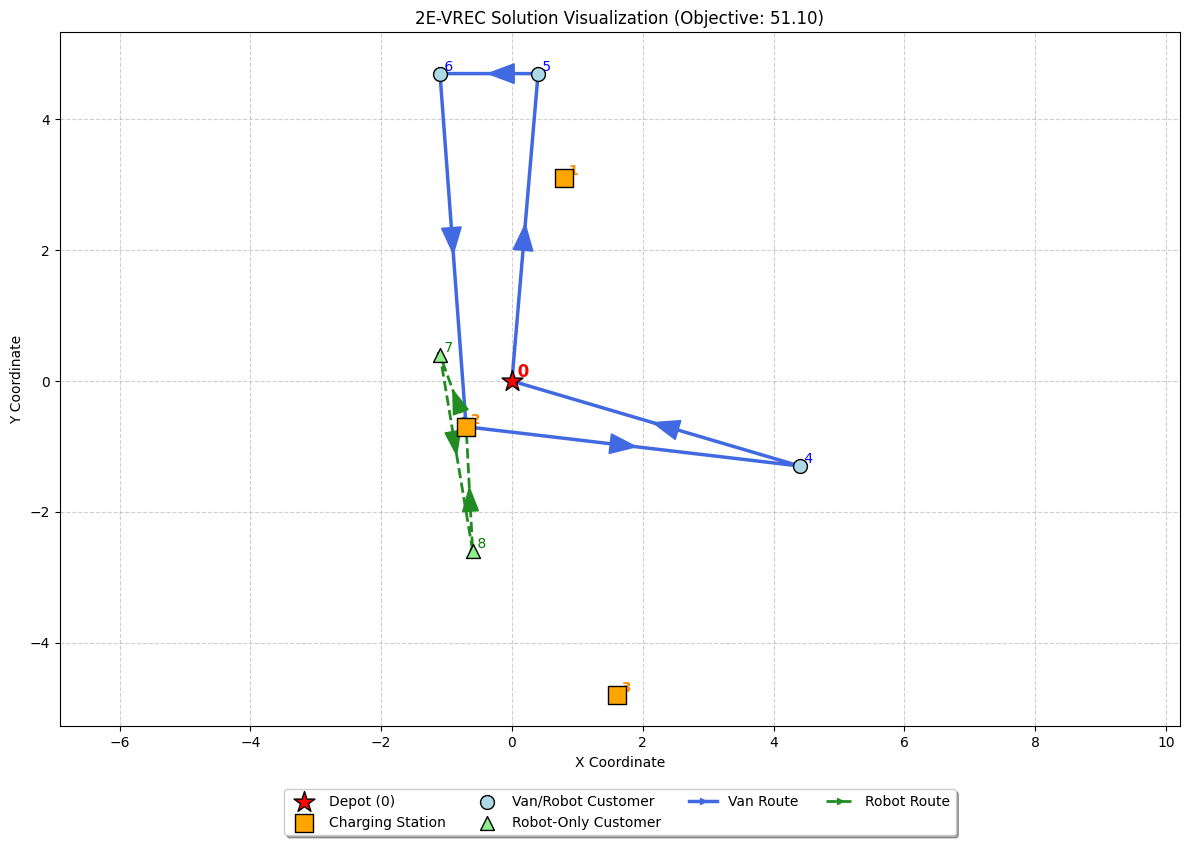

In [57]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_solution_with_routes(data, solution: VRPECSolution, figsize=(12, 9)):
    """
    Vẽ bản đồ với depot, CS, customers và các tuyến đường từ solution.

    Args:
        data (dict): Dictionary chứa tọa độ gốc từ read_testcase()
                     (keys: 'depot', 'parking_nodes_set', 'customers_set').
        solution (VRPECSolution): Đối tượng solution chứa kết quả routes.
        figsize (tuple): Kích thước của hình vẽ.
    """
    # Lấy dữ liệu tọa độ gốc
    depot_coord = data.get('depot', (0, 0))
    charging_station_coords = data.get('parking_nodes_set', [])
    customer_coords = data.get('customers_set', []) # List tất cả tọa độ khách hàng theo thứ tự gốc

    # --- Tạo mapping Node ID -> Tọa độ ---
    # Dựa trên thứ tự trong hàm old_input() và VRPECSolution:
    # 0: Depot
    # 1..N_cs: Charging Stations
    # N_cs+1 .. N_cs+N_both: Customers Both
    # N_cs+N_both+1 .. N: Customers Robot Only
    node_positions = {}
    node_positions[solution.depot] = depot_coord # Depot ID = 0

    node_id_counter = 1
    cs_id_map = {} # Map ID trong solution.charging_stations -> coordinate
    for cs_id in solution.charging_stations:
         # Giả định thứ tự CS trong solution.charging_stations khớp với data['parking_nodes_set']
         if (node_id_counter - 1) < len(charging_station_coords):
              coord = charging_station_coords[node_id_counter - 1]
              node_positions[cs_id] = coord
              cs_id_map[cs_id] = coord
         node_id_counter += 1


    cust_both_id_map = {}
    cust_robot_only_id_map = {}
    current_cust_index = 0 # Index vào list customer_coords gốc

    # Map IDs khách hàng 'both'
    for cust_id in solution.customers_both:
         if current_cust_index < len(customer_coords):
              coord = customer_coords[current_cust_index]
              node_positions[cust_id] = coord
              cust_both_id_map[cust_id] = coord
         current_cust_index += 1

    # Map IDs khách hàng 'robot_only'
    for cust_id in solution.customers_robot_only:
         if current_cust_index < len(customer_coords):
              coord = customer_coords[current_cust_index]
              node_positions[cust_id] = coord
              cust_robot_only_id_map[cust_id] = coord
         current_cust_index += 1

    # --- Bắt đầu vẽ ---
    plt.figure(figsize=figsize)
    ax = plt.gca() # Get current axes

    # --- Vẽ các điểm ---
    # Depot (ID 0)
    depot_x, depot_y = node_positions[solution.depot]
    ax.scatter(depot_x, depot_y, c='red', s=250, marker='*', edgecolors='black',
                zorder=10, label=f'Depot ({solution.depot})')
    ax.text(depot_x, depot_y, f" {solution.depot}", fontsize=12, ha='left', va='bottom', color='red', weight='bold')

    # Charging Stations
    cs_x = [coord[0] for coord in cs_id_map.values()]
    cs_y = [coord[1] for coord in cs_id_map.values()]
    ax.scatter(cs_x, cs_y, c='orange', s=150, marker='s', edgecolors='black',
                zorder=9, label='Charging Station')
    for cs_id, coord in cs_id_map.items():
        ax.text(coord[0], coord[1], f" {cs_id}", fontsize=10, ha='left', va='bottom', color='darkorange', weight='bold')

    # Customers - Van/Robot (both)
    if cust_both_id_map:
        both_x = [coord[0] for coord in cust_both_id_map.values()]
        both_y = [coord[1] for coord in cust_both_id_map.values()]
        ax.scatter(both_x, both_y, c='lightblue', s=100, marker='o', edgecolors='black',
                    zorder=8, label='Van/Robot Customer')
        for cust_id, coord in cust_both_id_map.items():
            ax.text(coord[0], coord[1], f" {cust_id}", fontsize=10, ha='left', va='bottom', color='blue')

    # Customers - Robot-Only
    if cust_robot_only_id_map:
        ro_x = [coord[0] for coord in cust_robot_only_id_map.values()]
        ro_y = [coord[1] for coord in cust_robot_only_id_map.values()]
        ax.scatter(ro_x, ro_y, c='lightgreen', s=100, marker='^', edgecolors='black', # Dùng marker khác
                    zorder=8, label='Robot-Only Customer')
        for cust_id, coord in cust_robot_only_id_map.items():
            ax.text(coord[0], coord[1], f" {cust_id}", fontsize=10, ha='left', va='bottom', color='green')

    # --- Vẽ các tuyến đường ---
    arrow_scale = 0.02 # Điều chỉnh kích thước mũi tên

    # Van Routes (màu xanh dương, liền nét)
    van_color = 'royalblue'
    for i, route in enumerate(solution.van_routes):
        route_nodes = route.nodes
        if len(route_nodes) < 2: continue
        # Vẽ đường nối các điểm
        route_x = [node_positions[node][0] for node in route_nodes if node in node_positions]
        route_y = [node_positions[node][1] for node in route_nodes if node in node_positions]
        ax.plot(route_x, route_y, color=van_color, linewidth=2.5, linestyle='-',
                 marker='>', markersize=5, # Thêm marker nhỏ chỉ hướng
                 zorder=5, label='Van Route' if i == 0 else "")

        # Vẽ mũi tên rõ ràng hơn ở giữa các đoạn
        for j in range(len(route_nodes) - 1):
            n1, n2 = route_nodes[j], route_nodes[j+1]
            if n1 in node_positions and n2 in node_positions:
                x1, y1 = node_positions[n1]
                x2, y2 = node_positions[n2]
                dx, dy = x2 - x1, y2 - y1
                if abs(dx) > 1e-6 or abs(dy) > 1e-6: # Check if nodes are distinct
                     ax.arrow(x1 + dx * 0.5, y1 + dy * 0.5, dx * 0.01, dy * 0.01, # Mũi tên nhỏ ở giữa
                               head_width=arrow_scale * 15, head_length=arrow_scale * 20,
                               fc=van_color, ec=van_color, zorder=6, length_includes_head=True)

    # Robot Routes (màu xanh lá, đứt nét)
    robot_color = 'forestgreen'
    for i, route in enumerate(solution.robot_routes):
        route_nodes = route.nodes
        if len(route_nodes) < 2: continue
        # Vẽ đường nối các điểm
        route_x = [node_positions[node][0] for node in route_nodes if node in node_positions]
        route_y = [node_positions[node][1] for node in route_nodes if node in node_positions]
        ax.plot(route_x, route_y, color=robot_color, linewidth=2, linestyle='--',
                 marker='>', markersize=4, # Thêm marker nhỏ chỉ hướng
                 zorder=5, label='Robot Route' if i == 0 else "")

        # Vẽ mũi tên rõ ràng hơn ở giữa các đoạn
        for j in range(len(route_nodes) - 1):
            n1, n2 = route_nodes[j], route_nodes[j+1]
            if n1 in node_positions and n2 in node_positions:
                x1, y1 = node_positions[n1]
                x2, y2 = node_positions[n2]
                dx, dy = x2 - x1, y2 - y1
                if abs(dx) > 1e-6 or abs(dy) > 1e-6:
                     ax.arrow(x1 + dx * 0.5, y1 + dy * 0.5, dx * 0.01, dy * 0.01,
                               head_width=arrow_scale * 12, head_length=arrow_scale * 18,
                               fc=robot_color, ec=robot_color, zorder=6, length_includes_head=True)

    # --- Hoàn thiện đồ thị ---
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(f"2E-VREC Solution Visualization (Objective: {solution.objective():.2f})")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
               fancybox=True, shadow=True, ncol=4) # Đặt legend bên dưới
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis('equal') # Đảm bảo tỉ lệแกน x và y bằng nhau
    plt.tight_layout(rect=[0, 0.05, 1, 1]) # Adjust layout to make space for legend
    plt.show()

visualize_solution_with_routes(res, best_solution, figsize=(12, 9))